# Лабораторная работа 1, Овчинников Дмитрий Максимович М8О-406Б-21

Делаем импорты для библиотек

In [141]:
# Куча импортов
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix, mean_absolute_error, root_mean_squared_error, r2_score
import seaborn as sns
import numpy as np
from scipy.spatial import distance
from collections import Counter
import matplotlib.pyplot as plt

## 1. Выбор начальных условий

Начнем с выбора датасета для классификации. Machine failure prediction. https://www.kaggle.com/datasets/umerrtx/machine-failure-prediction-using-sensor-data/data 
Понравилось, что в сложных системах мы обычно можем замерить данные с датчиков, однако определять на каждой машине когда пора делать замену деталей задача сложная для человека (Соответсвенно есть издержки на проверку каждого оборудования). Используя данные и модель - можно предсказать когда стоит заменить детали.

Также нет прикрепления к конкретному заводу, можно имея достаточные данные применить метод на разном предприятии.

Признаки числовые.

In [142]:
# Посмотрим как выглядят данные для классификации
machine_fails = pd.read_csv('./machine_fails.csv')
machine_fails.head()

,footfall,tempMode,AQ,USS,CS,VOC,RP,IP,Temperature,fail
0,0,7,7,1,6,6,36,3,1,1
1,190,1,3,3,5,1,20,4,1,0
2,31,7,2,2,6,1,24,6,1,0
3,83,4,3,4,5,1,28,6,1,0
4,640,7,5,6,4,0,68,6,1,0


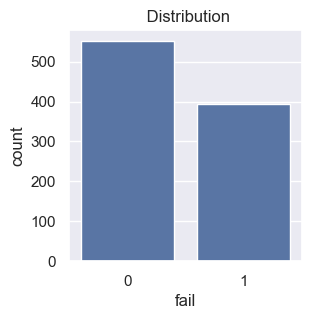

In [192]:
# Какие в целом есть распределения
fig = plt.figure(figsize=(3,3))
sns.set(style="darkgrid")
ax = sns.countplot(x = machine_fails["fail"] , data = machine_fails).set_title(" " + "Distribution")

<Axes: xlabel='Temperature', ylabel='USS'>

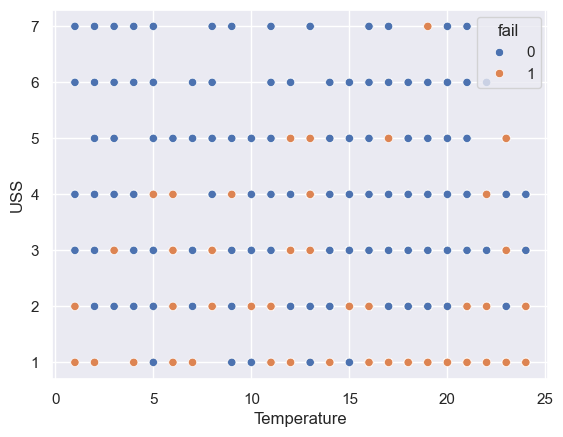

In [196]:
# Пример визуализации как зависили между собой параметры
sns.scatterplot(x=machine_fails['Temperature'], y=machine_fails['USS'], hue=machine_fails['fail'])

<Axes: >

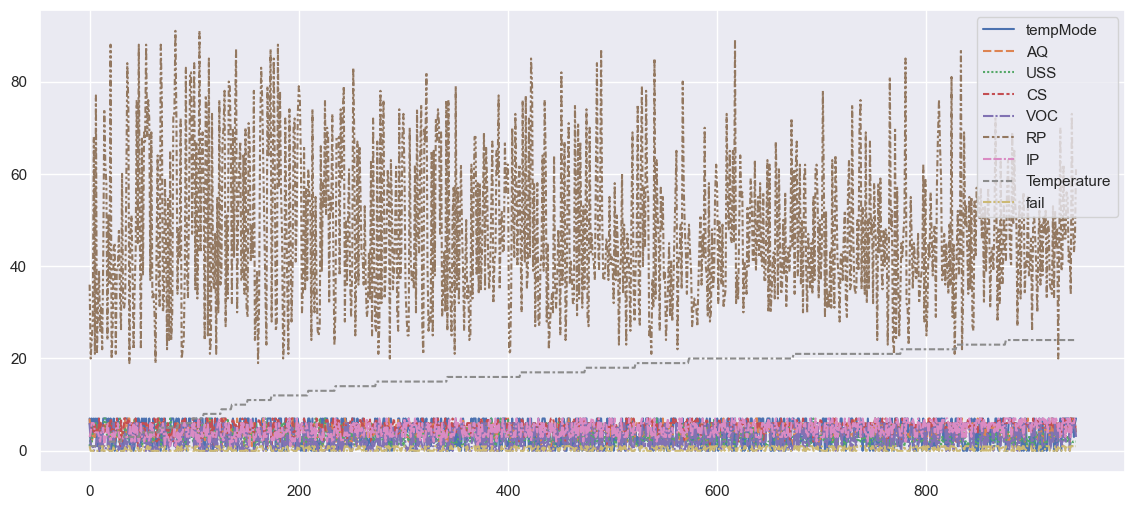

In [197]:
# Как в целом выглядят параметры в данных
plt.figure(figsize=(14,6))
sns.lineplot(data=machine_fails)

Для регрессии выбираю результативность студентов.
https://www.kaggle.com/datasets/nikhil7280/student-performance-multiple-linear-regression/data
Так как являюсь студентом вуза - интересно узнать сколько нужно использовать времени на свою активность, чтобы успешно подготовиться к экзаменам. Задача имеет практическое применение т.к будущий работник может использовать оставшееся время для подготовки к работе, либо развития себя. Тем самым можно на более раннем этапе получить работника - подмастерье.

Признаки в основном числовые, но есть категориальный (посещение внеучебных мероприятий)

In [143]:
# Посмотрим на данные для регресса
performanse = pd.read_csv('./Student_Performance.csv')
performanse.head()

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
0,7,99,Yes,9,1,91.0
1,4,82,No,4,2,65.0
2,8,51,Yes,7,2,45.0
3,5,52,Yes,5,2,36.0
4,7,75,No,8,5,66.0


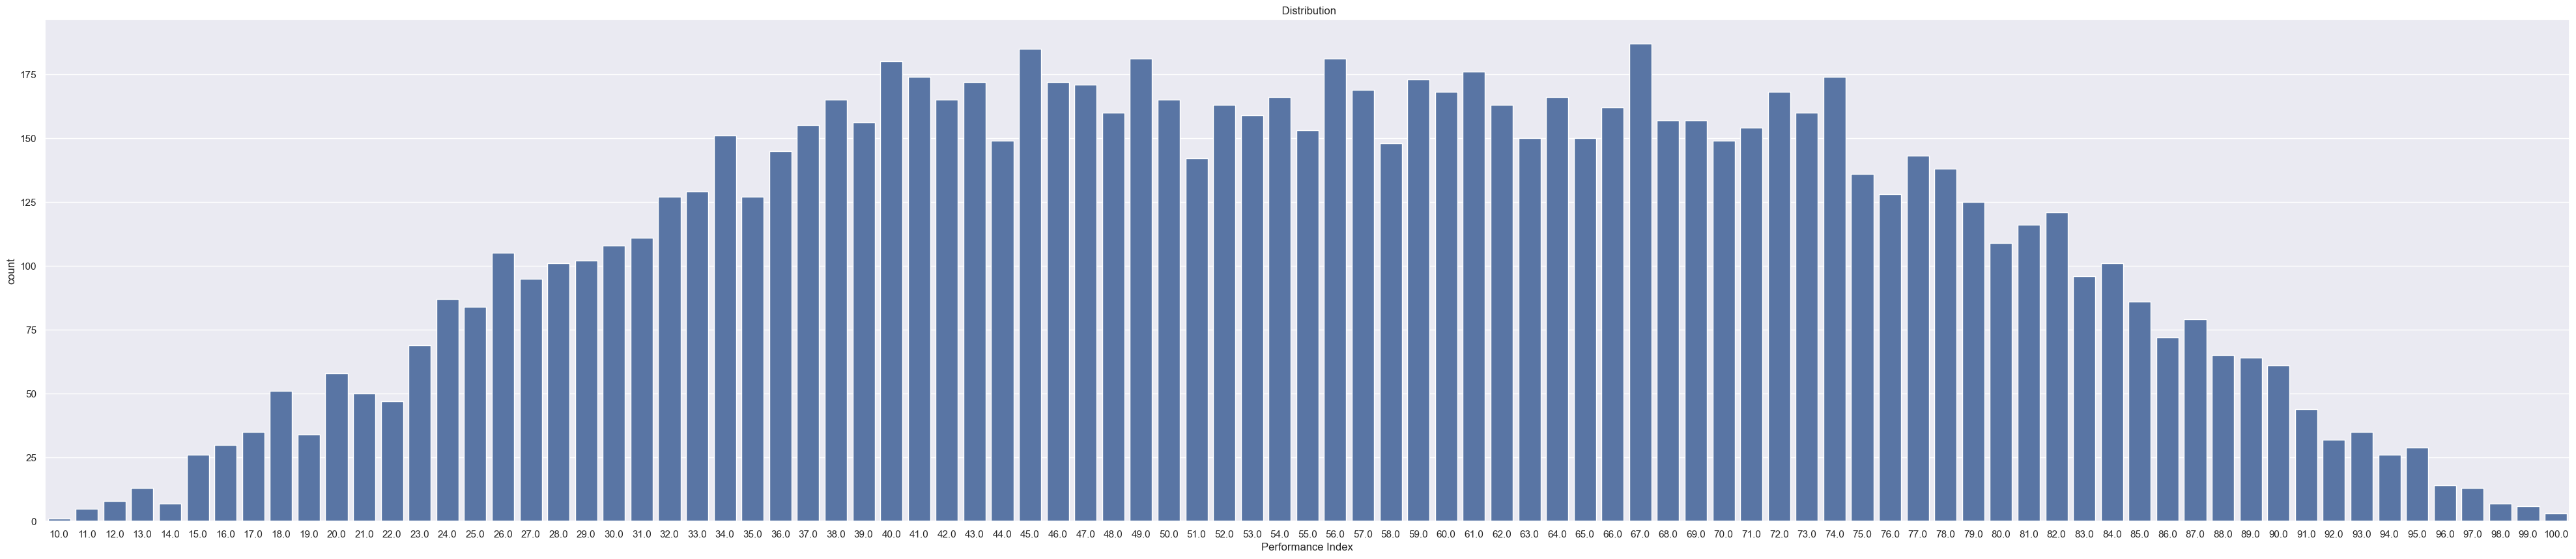

In [194]:
# Распределение PerformanceIndex
fig = plt.figure(figsize=(50,10))
sns.set(style="darkgrid")
ax = sns.countplot(x = performanse["Performance Index"] , data = performanse).set_title(" " + "Distribution")

<Axes: >

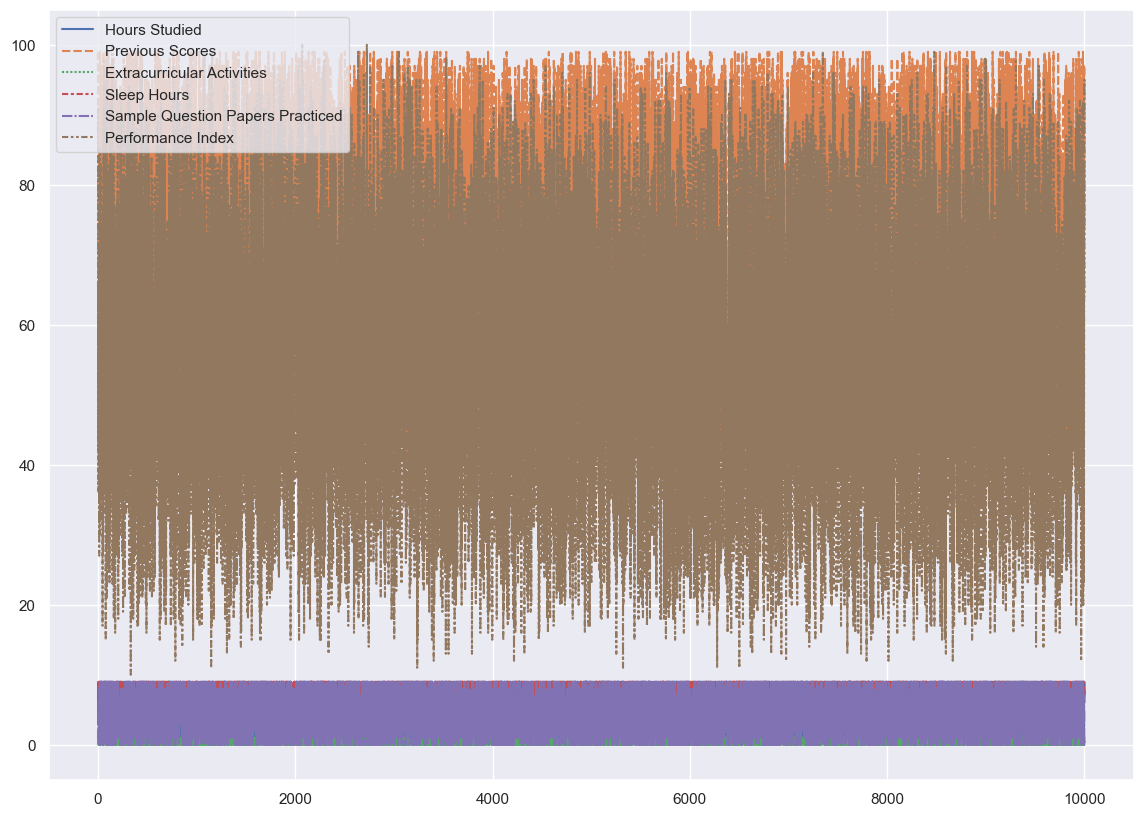

In [201]:
# Как в целом выглядят параметры в данных
plt.figure(figsize=(14,10))
sns.lineplot(data=performanse)

Выбор метрик качества.

Есть матрица ошибок.
В ней мы можем попасть в несколько случаев
$$
\begin{pmatrix}
 TN=true positive & FN=false negative \\
 TP=true negative & FP=false positive \\
\end{pmatrix}
$$
Ясно, что мы стремимся к увеличению диагональных элементов
Для классификации.
- Accuracy. (TN+TP)/(TN+TP+FN+FP)  
Но если есть перевес одного из классов (10 тыс норм машин, а 10 только сломались), то этот параметр будет под 99%, но не отражать реальность.
- F1-score. Тут появляется второй способ.  
Есть точность TP/(TP+FP) + полнота TP/(TP+FN).  
Данная F1 учитывает их.

Для регрессии
Mean Absolute Error - среднеквадратичная ошибка  
R^2 - Коэффициент детерминации

# BaseLine и оценка качества

In [144]:
# Функции для оценки Accuracy, F1, MAE, R2
def checkAccuracyReg(
        model,
        checkData,
        answers,
    ):
    knn_predictions = model.predict(checkData)
    mae = mean_absolute_error(knn_predictions, answers)
    r2 =  r2_score(knn_predictions, answers)
    return mae, r2

def checkAccuracyClassification(
        model,
        checkData,
        answers
    ):
    predictions = model.predict(checkData)
    accuracy = accuracy_score(predictions, answers)
    f1 = f1_score(predictions, answers, average='weighted')
    return accuracy, f1

# Использование Scaler
# Суть в том, что в колонках данные разные. где-то очень большие, где-то не очень.
# Как итог они не в равной степени влияют на ответ. 
# В итоге значения с разбросом от 1 до 10000 станут от -1 до 1, где среднее будет 0.
def scaleData(
    first,
    second
):
    scaler = StandardScaler()
    first_scaled = scaler.fit_transform(first)
    second_scaled = scaler.transform(second)
    return first_scaled, second_scaled

def scaleData(
    all_data
):
    scaler = StandardScaler()
    all_data_scalled = scaler.fit_transform(all_data)
    return all_data_scalled

In [145]:
# На куче обучающих статей в kaggle видел 42, практический смысл, что если обучить с таким семечком (seed), 
# то мы должны получать один и тот же результат в итоге, если захотим еще раз обучить модель
answer_for_life_universe_and_everything = 42

# В процессе работы обнаружил, что мы действтилельно имеем оооочень много повторений
# Как итог тут полагаясь на исходные данные + модель можно обучить ее и получить оценку насколько успешно получилось.
def fitModelClassificaion(
        model,
        X_param,
        y_answers
):
        X_train, X_test, y_train, y_test = train_test_split(X_param, y_answers, test_size=0.2, random_state=answer_for_life_universe_and_everything)
        model.fit(X_train, y_train)
        return checkAccuracyClassification(model, X_test, y_test)

def fitModelClassificaion_scaled(
        model,
        X_param,
        y_answers
):
        X_train, X_test, y_train, y_test = train_test_split(X_param, y_answers, test_size=0.2, random_state=answer_for_life_universe_and_everything)
        X_train_scaler = scaleData(X_train)
        X_test_scaler = scaleData(X_test)
        model.fit(X_train_scaler, y_train)
        return checkAccuracyClassification(model, X_test_scaler, y_test)

def fitModelRegression(
        model,
        X_param,
        y_answers
):
        X_train, X_test, y_train, y_test = train_test_split(X_param, y_answers, test_size=0.2, random_state=answer_for_life_universe_and_everything)
        model.fit(X_train, y_train)
        return checkAccuracyReg(model, X_test, y_test)

def fitModelRegression_scaled(
        model,
        X_param,
        y_answers
):
        X_train, X_test, y_train, y_test = train_test_split(X_param, y_answers, test_size=0.2, random_state=answer_for_life_universe_and_everything)
        X_train_scaler = scaleData(X_train)
        X_test_scaler = scaleData(X_test)
        model.fit(X_train_scaler, y_train)
        return checkAccuracyReg(model, X_test_scaler, y_test)

def grid_search_find_model(
    model,
    X_param,
    y_answers,
    param_grid
):
    X_train, X_test, y_train, y_test = train_test_split(X_param, y_answers, test_size=0.2, random_state=answer_for_life_universe_and_everything)
    grid = GridSearchCV(model, param_grid, cv=5)
    grid.fit(X_train, y_train)
    print(grid.best_params_)
    return grid.best_estimator_

In [146]:
# Определить есть ли значения пустые в датасете
# Соответственно модели не знают что делать с Null, NaN значениями, + мы сами можем определить нужны ли эти строки или нет.
print(machine_fails.isnull().values.any())
print(performanse.isnull().values.any())
print("--------")
# Детальнее
print(machine_fails.isnull().sum())
print("--------")
print(performanse.isnull().sum())
# Раз нет, то не нужно доп обработки, но иначе бы применил
# SimpleImputer(strategy='mean')

False
False
--------
footfall       0
tempMode       0
AQ             0
USS            0
CS             0
VOC            0
RP             0
IP             0
Temperature    0
fail           0
dtype: int64
--------
Hours Studied                       0
Previous Scores                     0
Extracurricular Activities          0
Sleep Hours                         0
Sample Question Papers Practiced    0
Performance Index                   0
dtype: int64


In [147]:
# Для пунктов лабораторной нужно сравнивать с П.2, П.3 свои имплементации.
# Данные функции как раз запоминают исходные значения для моделей и дальше можем из функций обучений выше забрать нужные данные.
class DiffMetricsClassification:
    def __init__(self, acc, f1):
        self.base_acc = acc
        self.base_f1 = f1
        print("Базовая Accuracy")
        print(f"{self.base_acc:.3f}")
        print("Базовая F1")
        print(f"{self.base_f1:.3f}")

    def calculate_difference(self, new_acc, new_f1):
        diff_acc = new_acc - self.base_acc
        diff_f1 = new_f1 - self.base_f1
        print(f"Accuracy {new_acc:.3f}")
        print(f"F1 {new_f1:.3f}")
        print(f"Diff Accuracy {diff_acc:.3f}")
        print(f"Diff F1 {diff_f1:.3f}")
        print()

class DiffMetricsRegression:
    def __init__(self, mae, r2):
        self.base_mae = mae
        self.base_r2 = r2
        print("Базовая Mae")
        print(f"{self.base_mae:.3f}")
        print("Базовая R^2")
        print(f"{self.base_r2:.3f}")

    def calculate_difference(self, new_mae, new_r2):
        diff_mae = new_mae - self.base_mae
        diff_r2 = new_r2 - self.base_r2
        print(f"Mae {new_mae:.3f}")
        print(f"R2 {new_r2:.3f}")
        print(f"Diff Mae {diff_mae:.3f}")
        print(f"Diff R2 {diff_r2:.3f}")
        print()

# Тут не хотелось выводить сразу базовые значения в print
class SilentDiffClassification:
    def __init__(self, acc, f1):
        self.base_acc = acc
        self.base_f1 = f1

    def calculate_difference(self, new_acc, new_f1):
        diff_acc = new_acc - self.base_acc
        diff_f1 = new_f1 - self.base_f1
        print("Сравнение с аналогичным пунктом:")
        print(f"Accuracy {new_acc:.3f}")
        print(f"F1 {new_f1:.3f}")
        print(f"Diff Accuracy {diff_acc:.3f}")
        print(f"Diff F1 {diff_f1:.3f}")
        print()

class SilentMetricsRegression:
    def __init__(self, mae, r2):
        self.base_mae = mae
        self.base_r2 = r2

    def calculate_difference(self, new_mae, new_r2):
        diff_mae = new_mae - self.base_mae
        diff_r2 = new_r2 - self.base_r2
        print("Сравнение с аналогичным пунктом:")
        print(f"Mae {new_mae:.3f}")
        print(f"R2 {new_r2:.3f}")
        print(f"Diff Mae {diff_mae:.3f}")
        print(f"Diff R2 {diff_r2:.3f}")
        print()


### a. Обучение модели из sklearn для классификации и оценка качества моделей по выбранным метрикам
#### Классификация
---

In [148]:
# Не нравится этот параметр footfall.
# Гипотеза, что сколько рядом прошло - не важные данные.
machine_fails = machine_fails.drop(['footfall'], axis = 'columns')

# Колонки по которым хотим искать ответ
X_fails = machine_fails.iloc[:, :-1]
# Колонка ответа.
y_fails = machine_fails.iloc[:, -1]

# Как происходит сплит на выборки обучения и теста (Дальше внутри функций уже есть)
X_train_fails, X_test_fails, y_train_fails, y_test_fails = train_test_split(X_fails, y_fails, test_size=0.2, random_state=answer_for_life_universe_and_everything)

In [149]:
orig_acc, orig_f1 = fitModelClassificaion(KNeighborsClassifier(n_neighbors=5), X_fails, y_fails)
base_differ_classification = DiffMetricsClassification(orig_acc, orig_f1)

Базовая Accuracy
0.852
Базовая F1
0.852


#### Регресс
---

In [150]:
# Избавляемся от категориальных признаков
performanse['Extracurricular Activities'] = performanse['Extracurricular Activities'].map({'Yes': 1, 'No': 0})

X_study = performanse.iloc[:, :-1]
y_study = performanse.iloc[:, -1]

X_train_study, X_test_study, y_train_study, y_test_study = train_test_split(X_study, y_study, test_size=0.2, random_state=answer_for_life_universe_and_everything)

In [151]:
orig_mae, orig_r2 = fitModelRegression(KNeighborsRegressor(n_neighbors=5), X_study, y_study)
base_differ_regression = DiffMetricsRegression(orig_mae, orig_r2)

Базовая Mae
1.967
Базовая R^2
0.983


### Улучшаем baseLine
---

In [ ]:
# Гепотизы просты - хотим привести к отклонению данных на 1 от нуля.
# Хотим добавить новый параметр, тем самым связав независимые параметры в исходных данных.
# Используем перебор параметров не входных данных, а исходной модели, т.к доступна  ее донастройка.
# Добавляем Scaler
new_acc, new_f1 = fitModelClassificaion_scaled(KNeighborsClassifier(n_neighbors=5), X_fails, y_fails)
print("Scaled: ")
base_differ_classification.calculate_difference(new_acc, new_f1)
base_scaler_class = SilentDiffClassification(new_acc, new_f1)

# Новый признак износ машины
X_fails_extra = X_fails.copy()
X_fails_extra["Extra Load"] = (X_fails_extra["RP"] * X_fails_extra["CS"])
print("New param: ")
extra_acc, extra_f1 = fitModelClassificaion_scaled(KNeighborsClassifier(n_neighbors=5), X_fails_extra, y_fails)
base_differ_classification.calculate_difference(extra_acc, extra_f1)
base_new_param_classification = SilentDiffClassification(extra_acc, extra_f1)

#Лучшая модель. Перебираем все варианты параметров
param_grid = {
    'n_neighbors': range(1, 5),
    'weights': ['uniform', 'distance'],
}
model_classification_greed = grid_search_find_model(KNeighborsClassifier(), X_fails, y_fails, param_grid)
print("Grid search: ")
best_model_acc, best_model_f1 = checkAccuracyClassification(model_classification_greed, X_test_fails, y_test_fails)
base_differ_classification.calculate_difference(best_model_acc, best_model_f1)


Scaled: 
Accuracy 0.857
F1 0.857
Diff Accuracy 0.005
Diff F1 0.006

New param: 
Accuracy 0.857
F1 0.857
Diff Accuracy 0.005
Diff F1 0.006

{'n_neighbors': 3, 'weights': 'uniform'}
Grid search: 
Accuracy 0.852
F1 0.852
Diff Accuracy 0.000
Diff F1 0.000



---

In [153]:
# Гепотизы просты - хотим привести к отклонению данных на 1 от нуля.
# Хотим добавить новый параметр, тем самым связав независимые параметры в исходных данных.
# Используем перебор параметров не входных данных, а исходной модели, т.к доступна  ее донастройка.

# Добавляем Scaler
print("Scaled: ")
new_mae, new_r2 = fitModelRegression_scaled(KNeighborsRegressor(n_neighbors=5), X_study, y_study)
base_differ_regression.calculate_difference(new_mae, new_r2)
base_scaler_regression = SilentMetricsRegression(new_mae, new_r2)

# Новый признак уровень счастья
print("New param:")
X_study_extra = X_study.copy()
X_study_extra["Happyness"] = X_study_extra.apply(
    lambda row: 2 if row["Sleep Hours"] > 8 and row["Extracurricular Activities"] == 1 
    else 1 if row["Sleep Hours"] > 8 or row["Extracurricular Activities"]
    else 0, axis=1)
extra_mae, extra_r2 = fitModelRegression(KNeighborsRegressor(n_neighbors=5), X_study_extra, y_study)
base_differ_regression.calculate_difference(extra_mae, extra_r2)
base_new_param_regression = SilentMetricsRegression(extra_mae, extra_r2)

#Подбор параметров модели, путем перебора 
print("grid search:")
param_grid = {
    'n_neighbors': range(1, 5),
    'weights': ['uniform', 'distance'],
    'metric': ['manhattan', 'euclidean']
}
model_classification_greed = grid_search_find_model(KNeighborsRegressor(), X_study, y_study, param_grid)
best_model_mae, best_model_r2 = checkAccuracyReg(model_classification_greed, X_test_study, y_test_study)
base_differ_regression.calculate_difference(best_model_mae, best_model_r2)

Scaled: 
Mae 2.313
R2 0.976
Diff Mae 0.345
Diff R2 -0.008

New param:
Mae 1.961
R2 0.983
Diff Mae -0.007
Diff R2 0.000

grid search:
{'metric': 'euclidean', 'n_neighbors': 4, 'weights': 'uniform'}
Mae 2.002
R2 0.982
Diff Mae 0.035
Diff R2 -0.001



In [154]:
# Свои имплементации
class KNNRegressor:
    def __init__(self, k=5, metric='euclidean', weights='uniform'):
        self.k = k
        self.metric = metric
        self.weights = weights

    def fit(self, X_train, y_train):
        self.X_train = X_train.to_numpy() if isinstance(X_train, pd.DataFrame) else X_train
        self.y_train = y_train.to_numpy() if isinstance(y_train, pd.Series) else y_train

    def predict(self, X_test):
        X_test = X_test.to_numpy() if isinstance(X_test, pd.DataFrame) else X_test
        return np.array([self._predict(x) for x in X_test])

    def _predict(self, x):
        x = np.array(x).reshape(1, -1)
        distances = distance.cdist(self.X_train, x, metric=self.metric).flatten()
        k_indices = np.argsort(distances)[:self.k]
        k_nearest_distances = distances[k_indices]
        k_nearest_labels = [self.y_train[i] for i in k_indices]

        if self.weights == 'uniform':
            return np.mean(k_nearest_labels)
        elif self.weights == 'distance':
            # Избегаем деления на ноль, если расстояние равно нулю
            weights = 1 / (k_nearest_distances + 1e-10)
            return np.dot(weights, k_nearest_labels) / np.sum(weights)
        else:
            raise ValueError("Параметр weights должен быть 'uniform' или 'distance'.")
        

class KNNClassifier:
    def __init__(self, k=5):
        self.k = k

    def fit(self, X_train, y_train):
        self.X_train = X_train.to_numpy() if isinstance(X_train, pd.DataFrame) else X_train
        self.y_train = y_train.to_numpy() if isinstance(y_train, pd.Series) else y_train

    def predict(self, X_test):
        X_test = X_test.to_numpy() if isinstance(X_test, pd.DataFrame) else X_test
        return np.array([self._predict(x) for x in X_test])

    def _predict(self, x):
        x = np.array(x).reshape(1, -1)
        distances = distance.cdist(self.X_train, x, 'euclidean').flatten()
        k_indices = np.argsort(distances)[:self.k]
        k_nearest_labels = [self.y_train[i] for i in k_indices]
        most_common = Counter(k_nearest_labels).most_common(1)
        return most_common[0][0]

---

In [155]:
# Пробуем обучить классификатор
impl_acc, impl_f1 = fitModelClassificaion(KNNClassifier(), X_fails, y_fails)
print("Self impl classification: ")
base_differ_classification.calculate_difference(impl_acc, impl_f1)
# Пробуем обучить регресс
impl_mae, impl_r2 = fitModelRegression(KNNRegressor(), X_study, y_study)
print("Self impl regression: ")
base_differ_regression.calculate_difference(impl_mae, impl_r2)

Self impl classification: 
Accuracy 0.852
F1 0.852
Diff Accuracy 0.000
Diff F1 0.000

Self impl regression: 
Mae 1.959
R2 0.983
Diff Mae -0.008
Diff R2 -0.000



---

In [156]:
# Добавляем Scaler
print("Scaled: ")
impl_new_acc, impl_new_f1 = fitModelClassificaion_scaled(KNNClassifier(), X_fails, y_fails)
base_scaler_class.calculate_difference(impl_new_acc, impl_new_f1)

# Новый параметр
print("New param: ")
impl_extra_acc, impl_extra_f1 = fitModelClassificaion_scaled(KNNClassifier(), X_fails_extra, y_fails)
base_new_param_classification.calculate_difference(impl_extra_acc, impl_extra_f1)

Scaled: 
Сравнение с аналогичным пунктом:
Accuracy 0.857
F1 0.857
Diff Accuracy 0.000
Diff F1 0.000

New param: 
Сравнение с аналогичным пунктом:
Accuracy 0.857
F1 0.857
Diff Accuracy 0.000
Diff F1 0.000



---

In [157]:
# Добавляем Scaler
print("Scaled: ")
impl_new_mae, impl_new_r2 = fitModelRegression_scaled(KNNRegressor(), X_study, y_study)
base_scaler_regression.calculate_difference(impl_new_mae, impl_new_r2)

# Новый параметр
impl_extra_mae, impl_extra_r2 = fitModelRegression_scaled(KNNRegressor(), X_study_extra, y_study)
base_new_param_regression.calculate_difference(impl_extra_mae, impl_extra_r2)

Scaled: 
Сравнение с аналогичным пунктом:
Mae 2.312
R2 0.976
Diff Mae -0.001
Diff R2 -0.000

Сравнение с аналогичным пунктом:
Mae 2.312
R2 0.976
Diff Mae 0.351
Diff R2 -0.008



---

Выводы общие.


Получилось обучить модели.

1) Исходные модели показали хороший результат. 0.85 для регресса. И R2 близкое к 1 (0.976). Результаты хорошие, т.к простой человек не смог бы с такой точностью обработать все данные.

2) Для улучшения - получен прирост для оценок классификации. Для регресса Mae стало ниже, что также говорит о лучшем резульате.  
Однако улучшение не очень улучшило базовую модель, что говорит о хороших исходных данных.

3) Собственнвая имплементация по оценкам не сильно уступает исходной.

----

Лабораторная 2

Примечание:
Т.к сделал общие функции выше - то в коде меняются переменные куда сохранить оценки, сами модели и их имплементации. Поэтому не добавлю полное описание к каждой ячейке.


In [158]:
from sklearn.linear_model import LogisticRegression, LinearRegression

Получаем исходные значения для моделей

In [159]:
log_orig_acc, log_orig_f1 = fitModelClassificaion(LogisticRegression(max_iter=1000, random_state=42), X_fails, y_fails)
log_base_differ_classification = DiffMetricsClassification(log_orig_acc, log_orig_f1)

lin_orig_mae, lin_orig_r2 = fitModelRegression(LinearRegression(), X_study, y_study)
lin_base_differ_regression = DiffMetricsRegression(lin_orig_mae, lin_orig_r2)

Базовая Accuracy
0.873
Базовая F1
0.873
Базовая Mae
1.611
Базовая R^2
0.989


In [160]:
# Добавляем Scaler
log_new_acc, log_new_f1 = fitModelClassificaion_scaled(LogisticRegression(max_iter=1000), X_fails, y_fails)
print("Scaled: ")
log_base_differ_classification.calculate_difference(log_new_acc, log_new_f1)
log_base_scaler_class = SilentDiffClassification(log_new_acc, log_new_f1)

# Новый признак износ машины
# X_fails_extra = X_fails.copy()
# X_fails_extra["Extra Load"] = (X_fails_extra["RP"] * X_fails_extra["CS"])
print("New param: ")
log_extra_acc, log_extra_f1 = fitModelClassificaion_scaled(LogisticRegression(max_iter=1000), X_fails_extra, y_fails)
log_base_differ_classification.calculate_difference(log_extra_acc, log_extra_f1)
log_base_new_param_classification = SilentDiffClassification(log_extra_acc, log_extra_f1)

#Лучшая модель
log_param_grid = {
    'C': [0.01, 0.1, 1, 10, 100]
}
log_model_classification_greed = grid_search_find_model(LogisticRegression(max_iter=1000), X_fails, y_fails, log_param_grid)
print("Grid search: ")
log_best_model_acc, log_best_model_f1 = checkAccuracyClassification(log_model_classification_greed, X_test_fails, y_test_fails)
log_base_differ_classification.calculate_difference(log_best_model_acc, log_best_model_f1)


Scaled: 
Accuracy 0.884
F1 0.884
Diff Accuracy 0.011
Diff F1 0.011

New param: 
Accuracy 0.884
F1 0.884
Diff Accuracy 0.011
Diff F1 0.011

{'C': 0.01}
Grid search: 
Accuracy 0.878
F1 0.878
Diff Accuracy 0.005
Diff F1 0.005



In [161]:
# Добавляем Scaler
print("Scaled: ")
lin_new_mae, lin_new_r2 = fitModelRegression_scaled(LinearRegression(), X_study, y_study)
lin_base_differ_regression.calculate_difference(lin_new_mae, lin_new_r2)
lin_base_scaler_regression = SilentMetricsRegression(lin_new_mae, lin_new_r2)

# Новый признак уровень счастья
print("New param:")
# X_study_extra = X_study.copy()
# X_study_extra["Happyness"] = X_study_extra.apply(
#     lambda row: 2 if row["Sleep Hours"] > 8 and row["Extracurricular Activities"] == 1 
#     else 1 if row["Sleep Hours"] > 8 or row["Extracurricular Activities"]
#     else 0, axis=1)
lin_extra_mae, lin_extra_r2 = fitModelRegression(LinearRegression(), X_study_extra, y_study)
lin_base_differ_regression.calculate_difference(lin_extra_mae, lin_extra_r2)
lin_base_new_param_regression = SilentMetricsRegression(lin_extra_mae, lin_extra_r2)

#Подбор параметров модели
print("grid search:")
lin_param_grid = {
    'fit_intercept': [True, False]
}
lin_model_classification_greed = grid_search_find_model(LinearRegression(), X_study, y_study, lin_param_grid)
lin_best_model_mae, lin_best_model_r2 = checkAccuracyReg(lin_model_classification_greed, X_test_study, y_test_study)
lin_base_differ_regression.calculate_difference(lin_best_model_mae, lin_best_model_r2)

Scaled: 
Mae 1.651
R2 0.988
Diff Mae 0.040
Diff R2 -0.000

New param:
Mae 1.612
R2 0.989
Diff Mae 0.001
Diff R2 -0.000

grid search:
{'fit_intercept': True}
Mae 1.611
R2 0.989
Diff Mae 0.000
Diff R2 0.000



In [168]:
class LogisticRegression2:
    def __init__(self, learning_rate=0.01, epochs=1000, regularization=None, reg_lambda=0.01):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.regularization = regularization
        self.reg_lambda = reg_lambda
        self.weights = None
        self.bias = None

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0

        for _ in range(self.epochs):
            linear_model = np.dot(X, self.weights) + self.bias
            y_predicted = self.sigmoid(linear_model)

            dw = (1 / n_samples) * np.dot(X.T, (y_predicted - y))
            db = (1 / n_samples) * np.sum(y_predicted - y)

            if self.regularization == 'l2':
                dw += (self.reg_lambda / n_samples) * self.weights
            elif self.regularization == 'l1':
                dw += (self.reg_lambda / n_samples) * np.sign(self.weights)

            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

    def predict(self, X):
        linear_model = np.dot(X, self.weights) + self.bias
        y_predicted = self.sigmoid(linear_model)
        return [1 if i > 0.5 else 0 for i in y_predicted]

In [163]:
import numpy as np
import pandas as pd

class LinearRegressor2:
    def __init__(self, method="direct"):
        self.beta = None
        self.method = method

    def fit(self, X, y, lr=3e-3, max_iter=100):
        X, y = self._prepare_inputs(X, y)
        X = self._add_bias(X)
        self.beta = np.random.randn(X.shape[1])
        if self.method == "direct":
            self._fit_direct(X, y)
        elif self.method == "iteract":
            self._fit_iteract(X, y, lr, max_iter)
        else:
            raise AttributeError("Нет такого метода")

    def _fit_direct(self, X: np.ndarray, y: np.ndarray):
        self.beta = np.linalg.pinv(X.T @ X) @ X.T @ y

    def _fit_iteract(self, X: np.ndarray, y: np.ndarray, lr, max_iter):
        for _ in range(max_iter):
            gradient = -2 / X.shape[0] * X.T @ (y - X @ self.beta)
            self.beta -= lr * gradient

    def predict(self, X):
        X = self._prepare_inputs(X)
        X = self._add_bias(X)
        return X @ self.beta

    @staticmethod
    def _add_bias(X: np.ndarray):
        return np.hstack((np.ones((X.shape[0], 1)), X))

    @staticmethod
    def _prepare_inputs(X, y=None):
        if isinstance(X, pd.DataFrame) or isinstance(X, pd.Series):
            X = X.values
        if isinstance(X, list):
            X = np.array(X)
        X = X.astype(float)

        if y is not None:
            if isinstance(y, pd.DataFrame) or isinstance(y, pd.Series):
                y = y.values
            if isinstance(y, list):
                y = np.array(y)
            if pd.api.types.is_categorical_dtype(y):
                y = y.astype(int)
            y = y.astype(float)
            return X, y

        return X

In [170]:
# Пробуем обучить классификатор
log_impl_acc, log_impl_f1 = fitModelClassificaion(LogisticRegression2(), X_fails, y_fails)
print("Self impl classification: ")
log_base_differ_classification.calculate_difference(log_impl_acc, log_impl_f1)
# Пробуем обучить регресс
lin_impl_mae, lin_impl_r2 = fitModelRegression(LinearRegressor2(), X_study, y_study)
print("Self impl regression: ")
lin_base_differ_regression.calculate_difference(lin_impl_mae, lin_impl_r2)

Self impl classification: 
Accuracy 0.873
F1 0.873
Diff Accuracy 0.000
Diff F1 0.000

Self impl regression: 
Mae 1.611
R2 0.989
Diff Mae 0.000
Diff R2 -0.000



/var/folders/rl/7qj77lh121lft5y0s77hpfrc0000gn/T/ipykernel_64848/1551823570.py:50: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(y):


In [171]:
# Добавляем Scaler
print("Scaled: ")
log_impl_new_acc, log_impl_new_f1 = fitModelClassificaion_scaled(LogisticRegression2(), X_fails, y_fails)
log_base_scaler_class.calculate_difference(log_impl_new_acc, log_impl_new_f1)

# Новый параметр
print("New param: ")
log_impl_extra_acc, log_impl_extra_f1 = fitModelClassificaion_scaled(LogisticRegression2(), X_fails_extra, y_fails)
log_base_new_param_classification.calculate_difference(log_impl_extra_acc, log_impl_extra_f1)

# Добавляем Scaler
print("Scaled: ")
lin_impl_new_mae, lin_impl_new_r2 = fitModelRegression_scaled(LinearRegressor2(), X_study, y_study)
lin_base_scaler_regression.calculate_difference(lin_impl_new_mae, lin_impl_new_r2)

# Новый параметр
lin_impl_extra_mae, lin_impl_extra_r2 = fitModelRegression_scaled(LinearRegressor2(), X_study_extra, y_study)
lin_base_new_param_regression.calculate_difference(lin_impl_extra_mae, lin_impl_extra_r2)

Scaled: 
Сравнение с аналогичным пунктом:
Accuracy 0.884
F1 0.884
Diff Accuracy 0.000
Diff F1 -0.000

New param: 
Сравнение с аналогичным пунктом:
Accuracy 0.884
F1 0.884
Diff Accuracy 0.000
Diff F1 -0.000

Scaled: 
Сравнение с аналогичным пунктом:
Mae 1.651
R2 0.988
Diff Mae 0.000
Diff R2 0.000

Сравнение с аналогичным пунктом:
Mae 1.652
R2 0.988
Diff Mae 0.040
Diff R2 -0.000



/var/folders/rl/7qj77lh121lft5y0s77hpfrc0000gn/T/ipykernel_64848/1551823570.py:50: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(y):
/var/folders/rl/7qj77lh121lft5y0s77hpfrc0000gn/T/ipykernel_64848/1551823570.py:50: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(y):


Выводы


Получилось обучить модели.

Результат лучше чем у KNN для соседей.

1) Исходные модели показали хороший результат. 0.873 для регресса. И R2 близкое к 1 (0.989). Результаты хорошие, т.к простой человек не смог бы с такой точностью обработать все данные.

2) Для улучшения - получен небольшой прирост для оценок классификации. Для регресса лучше не стало от техник.  
Однако улучшение не очень улучшило базовую модель, что говорит о хороших исходных данных.

3) Собственнвая имплементация по оценкам не сильно уступает исходной.

---

Лабораторная 3

In [172]:
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

In [173]:
tree_orig_acc, tree_orig_f1 = fitModelClassificaion(DecisionTreeClassifier(), X_fails, y_fails)
tree_base_differ_classification = DiffMetricsClassification(tree_orig_acc, tree_orig_f1)

tree_orig_mae, tree_orig_r2 = fitModelRegression(DecisionTreeRegressor(), X_study, y_study)
tree_base_differ_regression = DiffMetricsRegression(tree_orig_mae, tree_orig_r2)

Базовая Accuracy
0.810
Базовая F1
0.809
Базовая Mae
2.318
Базовая R^2
0.976


In [174]:
# Добавляем Scaler
tree_new_acc, tree_new_f1 = fitModelClassificaion_scaled(DecisionTreeClassifier(random_state=42), X_fails, y_fails)
print("Scaled: ")
tree_base_differ_classification.calculate_difference(tree_new_acc, tree_new_f1)
tree_base_scaler_class = SilentDiffClassification(tree_new_acc, tree_new_f1)

# Новый признак износ машины
# X_fails_extra = X_fails.copy()
# X_fails_extra["Extra Load"] = (X_fails_extra["RP"] * X_fails_extra["CS"])
print("New param: ")
tree_extra_acc, tree_extra_f1 = fitModelClassificaion_scaled(DecisionTreeClassifier(random_state=42), X_fails_extra, y_fails)
tree_base_differ_classification.calculate_difference(tree_extra_acc, tree_extra_f1)
tree_base_new_param_classification = SilentDiffClassification(tree_extra_acc, tree_extra_f1)

#Лучшая модель
tree_param_grid = {
    'max_depth': [5, 10, 15, 20, None],
    'min_samples_split': [5, 7, 10],
}
tree_model_classification_greed = grid_search_find_model(DecisionTreeClassifier(random_state=42), X_fails, y_fails, tree_param_grid)
print("Grid search: ")
tree_best_model_acc, tree_best_model_f1 = checkAccuracyClassification(tree_model_classification_greed, X_test_fails, y_test_fails)
tree_base_differ_classification.calculate_difference(tree_best_model_acc, tree_best_model_f1)


Scaled: 
Accuracy 0.815
F1 0.815
Diff Accuracy 0.005
Diff F1 0.005

New param: 
Accuracy 0.831
F1 0.830
Diff Accuracy 0.021
Diff F1 0.021

{'max_depth': 5, 'min_samples_split': 10}
Grid search: 
Accuracy 0.868
F1 0.868
Diff Accuracy 0.058
Diff F1 0.058



In [175]:
# Добавляем Scaler
print("Scaled: ")
tree_new_mae, tree_new_r2 = fitModelRegression_scaled(DecisionTreeRegressor(random_state=42), X_study, y_study)
tree_base_differ_regression.calculate_difference(tree_new_mae, tree_new_r2)
tree_base_scaler_regression = SilentMetricsRegression(tree_new_mae, tree_new_r2)

# Новый признак уровень счастья
print("New param:")
# X_study_extra = X_study.copy()
# X_study_extra["Happyness"] = X_study_extra.apply(
#     lambda row: 2 if row["Sleep Hours"] > 8 and row["Extracurricular Activities"] == 1 
#     else 1 if row["Sleep Hours"] > 8 or row["Extracurricular Activities"]
#     else 0, axis=1)
tree_extra_mae, tree_extra_r2 = fitModelRegression(DecisionTreeRegressor(random_state=42), X_study_extra, y_study)
tree_base_differ_regression.calculate_difference(tree_extra_mae, tree_extra_r2)
tree_base_new_param_regression = SilentMetricsRegression(tree_extra_mae, tree_extra_r2)

#Подбор параметров модели
print("grid search:")
tree_param_grid = {
    'max_depth': [5, 10, 15, 20, None],
    'min_samples_split': [5, 7, 10],
}
tree_model_classification_greed = grid_search_find_model(DecisionTreeRegressor(random_state=42), X_study, y_study, tree_param_grid)
tree_best_model_mae, tree_best_model_r2 = checkAccuracyReg(tree_model_classification_greed, X_test_study, y_test_study)
tree_base_differ_regression.calculate_difference(tree_best_model_mae, tree_best_model_r2)

Scaled: 
Mae 2.342
R2 0.976
Diff Mae 0.024
Diff R2 -0.000

New param:
Mae 2.342
R2 0.976
Diff Mae 0.024
Diff R2 -0.000

grid search:
{'max_depth': 10, 'min_samples_split': 10}
Mae 1.939
R2 0.983
Diff Mae -0.379
Diff R2 0.007



In [176]:
class Node:
    def __init__(self, threshold=None, idx_feature=None, criterion=None, parent=None, left_children=None, right_children=None, y_values=None):
        self.threshold = threshold
        self.idx_feature = idx_feature
        self.parent = parent
        self.left_children = left_children
        self.right_children = right_children
        self.y_values = y_values
        self.criterion = criterion

class DecisionTree:
    def __init__(self, max_depth=1000, min_leaf_split=2):
        self.root = None
        self.max_depth = max_depth
        self.min_leaf_split = min_leaf_split

    def fit(self, X, y):
        X, y = self._prepare_inputs(X, y)
        self.root = self.build_tree(X, y)

    def build_tree(self, X, y, parent=None, depth=0):
        if X.shape[0] <= self.min_leaf_split or depth >= self.max_depth:
            return Node(parent=parent, y_values=y)

        best_criterion, best_idx_feature, best_threshold = self.find_best_feature_split(X, y)

        if best_criterion is None or best_criterion <= 0:
            return Node(parent=parent, y_values=y)

        node = Node(threshold=best_threshold, idx_feature=best_idx_feature, criterion=best_criterion, parent=parent, y_values=y)

        left_mask = X[:, best_idx_feature] <= best_threshold
        right_mask = ~left_mask
        left_X, left_y = X[left_mask], y[left_mask]
        right_X, right_y = X[right_mask], y[right_mask]

        node.left_children = self.build_tree(left_X, left_y, parent=node, depth=depth + 1)
        node.right_children = self.build_tree(right_X, right_y, parent=node, depth=depth + 1)

        return node

    def predict(self, X) -> np.ndarray:
        """
        Прогнозирует метки классов для входных данных X.

        X: np.ndarray с признаками (n_samples, n_features).
        Возвращает: np.ndarray с предсказанными метками классов (n_samples,).
        """
        X = self._prepare_inputs(X)
        def traverse_batch(node, X_batch):
            if node.left_children is None and node.right_children is None:
                return np.full(X_batch.shape[0], self._predict_leaf(node), dtype=float)

            left_mask = X_batch[:, node.idx_feature] <= node.threshold
            right_mask = ~left_mask

            predictions = np.empty(X_batch.shape[0], dtype=float)
            if left_mask.any():
                predictions[left_mask] = traverse_batch(node.left_children, X_batch[left_mask])
            if right_mask.any():
                predictions[right_mask] = traverse_batch(node.right_children, X_batch[right_mask])
            return predictions

        return traverse_batch(self.root, X)

    def print_tree(self):
        """
        Отображает дерево решений в виде текста.
        """
        self._print_subtree(self.root)

    def _print_subtree(self, node, depth=0):
        if node is None:
            return
        indent = "  " * depth
        print(f"{indent}Node(threshold={node.threshold}, idx_feature={node.idx_feature}, criterion={node.criterion}, y_values={node.y_values})")
        self._print_subtree(node.left_children, depth + 1)
        self._print_subtree(node.right_children, depth + 1)


    def find_best_feature_split(self, X: np.ndarray, y: np.ndarray):
        best_idx_feature = None
        best_threshold = None
        best_criterion = 0

        for idx_feature in range(X.shape[1]):
            cur_criterion, cur_threshold = self.find_best_threshold_split(X[:, idx_feature], y)
            if cur_criterion > best_criterion:
                best_threshold = cur_threshold
                best_criterion = cur_criterion
                best_idx_feature = idx_feature

        return best_criterion, best_idx_feature, best_threshold

    def find_best_threshold_split(self, X_cols: np.ndarray, y: np.ndarray):
        best_criterion = 0
        best_threshold = None

        uniq_elem = np.unique(X_cols)
        for i in range(1, len(uniq_elem)):
            threshold = (uniq_elem[i-1] + uniq_elem[i]) / 2
            y_left, y_right = self.get_split(X_cols, y, threshold)
            cur_criterion = self.calculate_criterion(y, y_left, y_right)
            if cur_criterion > best_criterion:
                best_criterion = cur_criterion
                best_threshold = threshold

        return best_criterion, best_threshold

    def calculate_criterion(self, y: np.ndarray, y_left: np.ndarray, y_right: np.ndarray):
        total_len = len(y)
        len_left = len(y_left)
        len_right = len(y_right)

        if len_left == 0 or len_right == 0:
            return 0.0

        return (
            self.criterion(y)
            - (len_left / total_len * self.criterion(y_left)
            + len_right / total_len * self.criterion(y_right))
        )

    @staticmethod
    def get_split(X_cols, y, threshold):
        indices = X_cols <= threshold
        left = y[indices]
        right = y[~indices]
        return left, right

    @staticmethod
    def _prepare_inputs(X, y=None):
        if isinstance(X, pd.DataFrame) or isinstance(X, pd.Series):
            X = X.values
        if isinstance(X, list):
            X = np.array(X)
        X = X.astype(float)

        if y is not None:
            if isinstance(y, pd.DataFrame) or isinstance(y, pd.Series):
                y = y.values
            if isinstance(y, list):
                y = np.array(y)
            if pd.api.types.is_categorical_dtype(y):
                y = y.astype(int)
            y = y.astype(float)
            return X, y

        return X



class DecisionTreeClassifier(DecisionTree):
    def __init__(self, criterion = "gini", max_depth=10, min_leaf_split=2):
        super().__init__(max_depth, min_leaf_split)
        self.criterion = self.calculate_gini
        if criterion == "entropy":
            self.criterion = self.calculate_entropy

    def _predict_leaf(self, node: Node):
        """
        Предсказание для листового узла.
        Возвращает класс, который чаще всего встречается в y_values узла.
        """
        unique, counts = np.unique(node.y_values, return_counts=True)
        return unique[np.argmax(counts)]

    @staticmethod
    def calculate_gini(y: np.ndarray):
        sum_counts = len(y)
        unique_elements, counts = np.unique(y, return_counts=True)
        p_k = counts / sum_counts
        return 1 - np.sum(p_k * p_k).item()

    @staticmethod
    def calculate_entropy(y: np.ndarray):
        sum_counts = len(y)
        unique_elements, counts = np.unique(y, return_counts=True)
        p_k = counts / sum_counts
        log_p_k = np.where(p_k > 0, np.log(p_k) / np.log(2), 0.0)
        return - np.sum(p_k * log_p_k).item()




class DecisionTreeRegressor(DecisionTree):
    def __init__(self, max_depth=10, min_leaf_split=2):
        super().__init__(max_depth, min_leaf_split)
        self.criterion = self.calculate_mse

    def _predict_leaf(self, node: Node):
        """
        Предсказание для листового узла.
        Возвращает класс, который чаще всего встречается в y_values узла.
        """
        if node.y_values.size == 0:
            return 0.0
        return node.y_values.mean()

    @staticmethod
    def calculate_mse(y: np.ndarray):
        if y.size == 0:
            return 0.0
        y_pred = np.mean(y)
        mse = np.mean((y - y_pred) ** 2)
        return mse

In [177]:
# Пробуем обучить классификатор
tree_impl_acc, tree_impl_f1 = fitModelClassificaion(DecisionTreeClassifier(), X_fails, y_fails)
print("Self impl classification: ")
tree_base_differ_classification.calculate_difference(tree_impl_acc, tree_impl_f1)
# Пробуем обучить регресс
tree_impl_mae, tree_impl_r2 = fitModelRegression(DecisionTreeRegressor(), X_study, y_study)
print("Self impl regression: ")
tree_base_differ_regression.calculate_difference(tree_impl_mae, tree_impl_r2)

/var/folders/rl/7qj77lh121lft5y0s77hpfrc0000gn/T/ipykernel_64848/3300510207.py:144: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(y):
/var/folders/rl/7qj77lh121lft5y0s77hpfrc0000gn/T/ipykernel_64848/3300510207.py:144: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(y):


Self impl classification: 
Accuracy 0.820
F1 0.820
Diff Accuracy 0.011
Diff F1 0.011

Self impl regression: 
Mae 1.982
R2 0.982
Diff Mae -0.335
Diff R2 0.006



In [178]:
# Добавляем Scaler
print("Scaled: ")
tree_impl_new_acc, tree_impl_new_f1 = fitModelClassificaion_scaled(DecisionTreeClassifier(), X_fails, y_fails)
tree_base_scaler_class.calculate_difference(tree_impl_new_acc, tree_impl_new_f1)

# Новый параметр
print("New param: ")
tree_impl_extra_acc, tree_impl_extra_f1 = fitModelClassificaion_scaled(DecisionTreeClassifier(), X_fails_extra, y_fails)
tree_base_new_param_classification.calculate_difference(tree_impl_extra_acc, tree_impl_extra_f1)

# Добавляем Scaler
print("Scaled: ")
tree_impl_new_mae, tree_impl_new_r2 = fitModelRegression_scaled(DecisionTreeRegressor(), X_study, y_study)
tree_base_scaler_regression.calculate_difference(tree_impl_new_mae, tree_impl_new_r2)

# Новый параметр
tree_impl_extra_mae, tree_impl_extra_r2 = fitModelRegression_scaled(DecisionTreeRegressor(), X_study_extra, y_study)
tree_base_new_param_regression.calculate_difference(tree_impl_extra_mae, tree_impl_extra_r2)

Scaled: 
Сравнение с аналогичным пунктом:
Accuracy 0.815
F1 0.815
Diff Accuracy 0.000
Diff F1 0.000

New param: 


/var/folders/rl/7qj77lh121lft5y0s77hpfrc0000gn/T/ipykernel_64848/3300510207.py:144: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(y):
/var/folders/rl/7qj77lh121lft5y0s77hpfrc0000gn/T/ipykernel_64848/3300510207.py:144: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(y):


Сравнение с аналогичным пунктом:
Accuracy 0.831
F1 0.830
Diff Accuracy 0.000
Diff F1 -0.000

Scaled: 


/var/folders/rl/7qj77lh121lft5y0s77hpfrc0000gn/T/ipykernel_64848/3300510207.py:144: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(y):


Сравнение с аналогичным пунктом:
Mae 1.981
R2 0.982
Diff Mae -0.361
Diff R2 0.007



/var/folders/rl/7qj77lh121lft5y0s77hpfrc0000gn/T/ipykernel_64848/3300510207.py:144: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(y):


Сравнение с аналогичным пунктом:
Mae 1.958
R2 0.983
Diff Mae -0.384
Diff R2 0.006



Выводы

Получилось обучить модели.

Результаты хуже чем  впрошлых моделях.

1) Исходные модели показали хороший результат. 0.810 для регресса. И R2 близкое к 1 (0.976). Результаты хорошие, т.к простой человек не смог бы с такой точностью обработать все данные. Но могло быть и лучше для классификации.

2) Для улучшения - получен небольшой прирост для оценок классификации. Для регресса лучше стало, а лучший r2 стал 0.983. 

3) Собственнвая имплементация по оценкам не сильно уступает исходной.

---


Лабораторная 4

In [179]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

In [180]:
rand_tree_orig_acc, rand_tree_orig_f1 = fitModelClassificaion(RandomForestClassifier(), X_fails, y_fails)
rand_tree_base_differ_classification = DiffMetricsClassification(rand_tree_orig_acc, rand_tree_orig_f1)

rand_tree_orig_mae, rand_tree_orig_r2 = fitModelRegression(RandomForestRegressor(), X_study, y_study)
rand_tree_base_differ_regression = DiffMetricsRegression(rand_tree_orig_mae, rand_tree_orig_r2)

Базовая Accuracy
0.873
Базовая F1
0.873
Базовая Mae
1.817
Базовая R^2
0.986


In [182]:
# Добавляем Scaler
rand_tree_new_acc, rand_tree_new_f1 = fitModelClassificaion_scaled(RandomForestClassifier(random_state=42), X_fails, y_fails)
print("Scaled: ")
rand_tree_base_differ_classification.calculate_difference(rand_tree_new_acc, rand_tree_new_f1)
rand_tree_base_scaler_class = SilentDiffClassification(rand_tree_new_acc, rand_tree_new_f1)

# Новый признак износ машины
# X_fails_extra = X_fails.copy()
# X_fails_extra["Extra Load"] = (X_fails_extra["RP"] * X_fails_extra["CS"])
print("New param: ")
rand_tree_extra_acc, rand_tree_extra_f1 = fitModelClassificaion_scaled(RandomForestClassifier(random_state=42), X_fails_extra, y_fails)
rand_tree_base_differ_classification.calculate_difference(rand_tree_extra_acc, rand_tree_extra_f1)
rand_tree_base_new_param_classification = SilentDiffClassification(rand_tree_extra_acc, rand_tree_extra_f1)

#Лучшая модель
rand_tree_param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7, None],
    'min_samples_split': [3, 5, 7]
}
rand_tree_model_classification_greed = grid_search_find_model(RandomForestClassifier(random_state=42), X_fails, y_fails, rand_tree_param_grid)
print("Grid search: ")
rand_tree_best_model_acc, rand_tree_best_model_f1 = checkAccuracyClassification(rand_tree_model_classification_greed, X_test_fails, y_test_fails)
rand_tree_base_differ_classification.calculate_difference(rand_tree_best_model_acc, rand_tree_best_model_f1)


Scaled: 
Accuracy 0.873
F1 0.873
Diff Accuracy 0.000
Diff F1 0.000

New param: 
Accuracy 0.884
F1 0.884
Diff Accuracy 0.011
Diff F1 0.011

{'max_depth': None, 'min_samples_split': 3, 'n_estimators': 100}
Grid search: 
Accuracy 0.878
F1 0.878
Diff Accuracy 0.005
Diff F1 0.005



In [183]:
# Добавляем Scaler
print("Scaled: ")
rand_tree_new_mae, rand_tree_new_r2 = fitModelRegression_scaled(RandomForestRegressor(random_state=42), X_study, y_study)
rand_tree_base_differ_regression.calculate_difference(rand_tree_new_mae, rand_tree_new_r2)
rand_tree_base_scaler_regression = SilentMetricsRegression(rand_tree_new_mae, rand_tree_new_r2)

# Новый признак уровень счастья
print("New param:")
# X_study_extra = X_study.copy()
# X_study_extra["Happyness"] = X_study_extra.apply(
#     lambda row: 2 if row["Sleep Hours"] > 8 and row["Extracurricular Activities"] == 1 
#     else 1 if row["Sleep Hours"] > 8 or row["Extracurricular Activities"]
#     else 0, axis=1)
rand_tree_extra_mae, rand_tree_extra_r2 = fitModelRegression(RandomForestRegressor(random_state=42), X_study_extra, y_study)
rand_tree_base_differ_regression.calculate_difference(rand_tree_extra_mae, rand_tree_extra_r2)
rand_tree_base_new_param_regression = SilentMetricsRegression(rand_tree_extra_mae, rand_tree_extra_r2)

#Подбор параметров модели
print("grid search:")
rand_tree_param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7, None],
    'min_samples_split': [3, 5, 7]
}
rand_tree_model_classification_greed = grid_search_find_model(RandomForestRegressor(random_state=42), X_study, y_study, rand_tree_param_grid)
rand_tree_best_model_mae, rand_tree_best_model_r2 = checkAccuracyReg(rand_tree_model_classification_greed, X_test_study, y_test_study)
rand_tree_base_differ_regression.calculate_difference(rand_tree_best_model_mae, rand_tree_best_model_r2)

Scaled: 
Mae 1.819
R2 0.986
Diff Mae 0.002
Diff R2 -0.000

New param:
Mae 1.813
R2 0.986
Diff Mae -0.004
Diff R2 0.000

grid search:
{'max_depth': None, 'min_samples_split': 7, 'n_estimators': 150}
Mae 1.743
R2 0.987
Diff Mae -0.074
Diff R2 0.001



In [184]:
from concurrent.futures import ProcessPoolExecutor
import os
import pandas as pd
from joblib import Parallel, delayed
import numpy as np
class RandomForest:
    def __init__(self, max_depth=5, min_leaf_split=10, n_estimators=10, max_features="n", use_bootstrap=True, n_jobs=-1):
        self.max_features = max_features
        self.n_estimators = n_estimators
        self.use_bootstrap = use_bootstrap
        if n_jobs == -1:
            self.n_jobs = os.cpu_count()
        elif n_jobs <= 0:
            raise ValueError("n_jobs должно быть больше 0 или равно -1 (используются все ядра)")
        else:
            self.n_jobs = n_jobs

        self.models = [self.class_simple_model(max_depth=max_depth, min_leaf_split=min_leaf_split)
                       for _ in range(self.n_estimators)]

    def fit(self, X, y):
        self.calc_max_features(X.shape[1])
        X, y = self._prepare_inputs(X, y)

        def train_single_model(model):
            X_bootstrap, y_bootstrap = self.bootstrap(X, y)
            selected_indices = self.subspace_indices(X.shape[1])
            trained_model = self._fit_model(model, X_bootstrap[:, selected_indices], y_bootstrap)
            return selected_indices, trained_model

        results = Parallel(n_jobs=self.n_jobs)(delayed(train_single_model)(m) for m in self.models)

        self.feature_indices, self.models = zip(*results)
        self.feature_indices = list(self.feature_indices)
        self.models = list(self.models)

    def _fit_model(self, model, X, y):
        model.fit(X, y)
        return model

    def subspace_indices(self, feature_count):
        return np.random.choice(feature_count, size=self.max_features, replace=False)

    def calc_max_features(self, feature_count):
        if self.max_features == "sqrt":
            self.max_features = int(np.sqrt(feature_count))
        elif self.max_features == "log2":
            self.max_features = int(np.log2(feature_count))
        else:
            self.max_features = feature_count

    def bootstrap(self, X, y):
        if self.use_bootstrap:
            n_samples = X.shape[0]
            indices = np.random.choice(n_samples, size=n_samples, replace=True)
            X_bootstrap = X[indices]
            y_bootstrap = y[indices]
            return X_bootstrap, y_bootstrap
        return X, y

    def subspace(self, X):
        selected_indices = np.random.choice(X.shape[1], size=self.max_features, replace=False)
        X_subspace = X[:, selected_indices]
        return X_subspace

    @staticmethod
    def _prepare_inputs(X, y=None):
        if isinstance(X, pd.DataFrame) or isinstance(X, pd.Series):
            X = X.values
        if isinstance(X, list):
            X = np.array(X)
        X = X.astype(float)

        if y is not None:
            if isinstance(y, pd.DataFrame) or isinstance(y, pd.Series):
                y = y.values
            if isinstance(y, list):
                y = np.array(y)
            if pd.api.types.is_categorical_dtype(y):
                y = y.astype(int)
            y = y.astype(float)
            return X, y

        return X

class RandomForestClassifier2(RandomForest):
    def __init__(self, max_depth=5, min_leaf_split=10, n_estimators=10, max_features="n", use_bootstrap=True, n_jobs=-1):
        self.class_simple_model = DecisionTreeClassifier
        super().__init__(max_depth, min_leaf_split, n_estimators, max_features, use_bootstrap, n_jobs)

    def predict(self, X):
        X = self._prepare_inputs(X)
        def predict_single_model(i):
            return self.models[i].predict(X[:, self.feature_indices[i]])

        predictions = Parallel(n_jobs=self.n_jobs)(
            delayed(predict_single_model)(i) for i in range(len(self.models))
        )
        predictions = np.array(predictions)

        final_predictions = []
        for i in range(predictions.shape[1]):
            uniq, counts = np.unique(predictions[:, i], return_counts=True)
            final_predictions.append(uniq[np.argmax(counts)])

        return np.array(final_predictions, dtype=int)


class RandomForestRegressor2(RandomForest):
    def __init__(self, max_depth=5, min_leaf_split=10, n_estimators=10, max_features="n", use_bootstrap=True, n_jobs=-1):
        self.class_simple_model = DecisionTreeRegressor
        super().__init__(max_depth, min_leaf_split, n_estimators, max_features, use_bootstrap, n_jobs)

    def predict(self, X):
        X = self._prepare_inputs(X)
        def predict_single_model(i):
            return self.models[i].predict(X[:, self.feature_indices[i]])

        predictions = Parallel(n_jobs=self.n_jobs)(
            delayed(predict_single_model)(i) for i in range(len(self.models))
        )
        predictions = np.array(predictions)
        predictions = np.mean(predictions, axis=0)

        return predictions

In [185]:
# Пробуем обучить классификатор
rand_tree_impl_acc, rand_tree_impl_f1 = fitModelClassificaion(RandomForestClassifier2(), X_fails, y_fails)
print("Self impl classification: ")
rand_tree_base_differ_classification.calculate_difference(rand_tree_impl_acc, rand_tree_impl_f1)
# Пробуем обучить регресс
rand_tree_impl_mae, rand_tree_impl_r2 = fitModelRegression(RandomForestRegressor2(), X_study, y_study)
print("Self impl regression: ")
rand_tree_base_differ_regression.calculate_difference(rand_tree_impl_mae, rand_tree_impl_r2)

/var/folders/rl/7qj77lh121lft5y0s77hpfrc0000gn/T/ipykernel_64848/1091420394.py:79: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(y):
/var/folders/rl/7qj77lh121lft5y0s77hpfrc0000gn/T/ipykernel_64848/3300510207.py:144: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
/var/folders/rl/7qj77lh121lft5y0s77hpfrc0000gn/T/ipykernel_64848/3300510207.py:144: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
/var/folders/rl/7qj77lh121lft5y0s77hpfrc0000gn/T/ipykernel_64848/3300510207.py:144: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
/var/folders/rl/7qj77lh121lft5y0s7

Self impl classification: 
Accuracy 0.878
F1 0.878
Diff Accuracy 0.005
Diff F1 0.005



/var/folders/rl/7qj77lh121lft5y0s77hpfrc0000gn/T/ipykernel_64848/1091420394.py:79: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(y):
/var/folders/rl/7qj77lh121lft5y0s77hpfrc0000gn/T/ipykernel_64848/3300510207.py:144: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
/var/folders/rl/7qj77lh121lft5y0s77hpfrc0000gn/T/ipykernel_64848/3300510207.py:144: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
/var/folders/rl/7qj77lh121lft5y0s77hpfrc0000gn/T/ipykernel_64848/3300510207.py:144: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
/var/folders/rl/7qj77lh121lft5y0s7

Self impl regression: 
Mae 2.394
R2 0.974
Diff Mae 0.577
Diff R2 -0.012



In [186]:
# Добавляем Scaler
print("Scaled: ")
rand_tree_impl_new_acc, rand_tree_impl_new_f1 = fitModelClassificaion_scaled(RandomForestClassifier2(), X_fails, y_fails)
rand_tree_base_scaler_class.calculate_difference(rand_tree_impl_new_acc, rand_tree_impl_new_f1)

# Новый параметр
print("New param: ")
rand_tree_impl_extra_acc, rand_tree_impl_extra_f1 = fitModelClassificaion_scaled(RandomForestClassifier2(), X_fails_extra, y_fails)
rand_tree_base_new_param_classification.calculate_difference(rand_tree_impl_extra_acc, rand_tree_impl_extra_f1)

# Добавляем Scaler
print("Scaled: ")
rand_tree_impl_new_mae, rand_tree_impl_new_r2 = fitModelRegression_scaled(RandomForestRegressor2(), X_study, y_study)
rand_tree_base_scaler_regression.calculate_difference(rand_tree_impl_new_mae, rand_tree_impl_new_r2)

# Новый параметр
rand_tree_impl_extra_mae, rand_tree_impl_extra_r2 = fitModelRegression_scaled(RandomForestRegressor2(), X_study_extra, y_study)
rand_tree_base_new_param_regression.calculate_difference(rand_tree_impl_extra_mae, rand_tree_impl_extra_r2)

Scaled: 


/var/folders/rl/7qj77lh121lft5y0s77hpfrc0000gn/T/ipykernel_64848/1091420394.py:79: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(y):
/var/folders/rl/7qj77lh121lft5y0s77hpfrc0000gn/T/ipykernel_64848/3300510207.py:144: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
/var/folders/rl/7qj77lh121lft5y0s77hpfrc0000gn/T/ipykernel_64848/3300510207.py:144: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
/var/folders/rl/7qj77lh121lft5y0s77hpfrc0000gn/T/ipykernel_64848/3300510207.py:144: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
/var/folders/rl/7qj77lh121lft5y0s7

Сравнение с аналогичным пунктом:
Accuracy 0.878
F1 0.878
Diff Accuracy 0.005
Diff F1 0.005

New param: 


/var/folders/rl/7qj77lh121lft5y0s77hpfrc0000gn/T/ipykernel_64848/1091420394.py:79: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(y):
/var/folders/rl/7qj77lh121lft5y0s77hpfrc0000gn/T/ipykernel_64848/3300510207.py:144: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
/var/folders/rl/7qj77lh121lft5y0s77hpfrc0000gn/T/ipykernel_64848/3300510207.py:144: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
/var/folders/rl/7qj77lh121lft5y0s77hpfrc0000gn/T/ipykernel_64848/3300510207.py:144: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
/var/folders/rl/7qj77lh121lft5y0s7

Сравнение с аналогичным пунктом:
Accuracy 0.878
F1 0.878
Diff Accuracy -0.005
Diff F1 -0.005

Scaled: 


/var/folders/rl/7qj77lh121lft5y0s77hpfrc0000gn/T/ipykernel_64848/1091420394.py:79: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(y):
/var/folders/rl/7qj77lh121lft5y0s77hpfrc0000gn/T/ipykernel_64848/3300510207.py:144: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
/var/folders/rl/7qj77lh121lft5y0s77hpfrc0000gn/T/ipykernel_64848/3300510207.py:144: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
/var/folders/rl/7qj77lh121lft5y0s77hpfrc0000gn/T/ipykernel_64848/3300510207.py:144: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
/var/folders/rl/7qj77lh121lft5y0s7

Сравнение с аналогичным пунктом:
Mae 2.459
R2 0.973
Diff Mae 0.640
Diff R2 -0.013



/var/folders/rl/7qj77lh121lft5y0s77hpfrc0000gn/T/ipykernel_64848/1091420394.py:79: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(y):
/var/folders/rl/7qj77lh121lft5y0s77hpfrc0000gn/T/ipykernel_64848/3300510207.py:144: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
/var/folders/rl/7qj77lh121lft5y0s77hpfrc0000gn/T/ipykernel_64848/3300510207.py:144: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
/var/folders/rl/7qj77lh121lft5y0s77hpfrc0000gn/T/ipykernel_64848/3300510207.py:144: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
/var/folders/rl/7qj77lh121lft5y0s7

Сравнение с аналогичным пунктом:
Mae 2.369
R2 0.975
Diff Mae 0.556
Diff R2 -0.011



Выводы

Получилось обучить модели.

На удивление рандомный лес основан на обычном. А резульат мы получили лучше прошлого

1) Исходные модели показали хороший результат. 0.873 для регресса. И R2 близкое к 1 (0.989). Результаты хорошие, т.к простой человек не смог бы с такой точностью обработать все данные.

2) Для улучшения - получен небольшой прирост как для классификации, так и для регресса.

3) Собственнвая имплементация по оценкам не сильно уступает исходной.

---
Лабораторная 5

In [187]:
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor

In [188]:
grad_orig_acc, grad_orig_f1 = fitModelClassificaion(GradientBoostingClassifier(), X_fails, y_fails)
grad_base_differ_classification = DiffMetricsClassification(grad_orig_acc, grad_orig_f1)

grad_orig_mae, grad_orig_r2 = fitModelRegression(GradientBoostingRegressor(), X_study, y_study)
grad_base_differ_regression = DiffMetricsRegression(grad_orig_mae, grad_orig_r2)

Базовая Accuracy
0.884
Базовая F1
0.884
Базовая Mae
1.658
Базовая R^2
0.988


In [189]:
# Добавляем Scaler
grad_new_acc, grad_new_f1 = fitModelClassificaion_scaled(GradientBoostingClassifier(random_state=42), X_fails, y_fails)
print("Scaled: ")
rand_tree_base_differ_classification.calculate_difference(grad_new_acc, grad_new_f1)
grad_base_scaler_class = SilentDiffClassification(grad_new_acc, grad_new_f1)

# Новый признак износ машины
# X_fails_extra = X_fails.copy()
# X_fails_extra["Extra Load"] = (X_fails_extra["RP"] * X_fails_extra["CS"])
print("New param: ")
grad_extra_acc, grad_extra_f1 = fitModelClassificaion_scaled(GradientBoostingClassifier(random_state=42), X_fails_extra, y_fails)
grad_base_differ_classification.calculate_difference(grad_extra_acc, grad_extra_f1)
grad_base_new_param_classification = SilentDiffClassification(grad_extra_acc, grad_extra_f1)

#Лучшая модель
grad_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}
grad_model_classification_greed = grid_search_find_model(GradientBoostingClassifier(random_state=42), X_fails, y_fails, grad_param_grid)
print("Grid search: ")
grad_best_model_acc, grad_best_model_f1 = checkAccuracyClassification(grad_model_classification_greed, X_test_fails, y_test_fails)
grad_base_differ_classification.calculate_difference(grad_best_model_acc, grad_best_model_f1)

Scaled: 
Accuracy 0.884
F1 0.884
Diff Accuracy 0.011
Diff F1 0.011

New param: 
Accuracy 0.884
F1 0.884
Diff Accuracy 0.000
Diff F1 0.000

{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Grid search: 
Accuracy 0.884
F1 0.884
Diff Accuracy 0.000
Diff F1 0.000



In [135]:
# Добавляем Scaler
print("Scaled: ")
grad_new_mae, grad_new_r2 = fitModelRegression_scaled(GradientBoostingRegressor(random_state=42), X_study, y_study)
grad_base_differ_regression.calculate_difference(grad_new_mae, grad_new_r2)
grad_base_scaler_regression = SilentMetricsRegression(grad_new_mae, grad_new_r2)

# Новый признак уровень счастья
print("New param:")
# X_study_extra = X_study.copy()
# X_study_extra["Happyness"] = X_study_extra.apply(
#     lambda row: 2 if row["Sleep Hours"] > 8 and row["Extracurricular Activities"] == 1 
#     else 1 if row["Sleep Hours"] > 8 or row["Extracurricular Activities"]
#     else 0, axis=1)
grad_extra_mae, grad_extra_r2 = fitModelRegression(GradientBoostingRegressor(random_state=42), X_study_extra, y_study)
grad_base_differ_regression.calculate_difference(grad_extra_mae, grad_extra_r2)
grad_base_new_param_regression = SilentMetricsRegression(grad_extra_mae, grad_extra_r2)

#Подбор параметров модели
print("grid search:")
grad_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}
grad_model_classification_greed = grid_search_find_model(GradientBoostingRegressor(random_state=42), X_study, y_study, grad_param_grid)
grad_best_model_mae, grad_best_model_r2 = checkAccuracyReg(grad_model_classification_greed, X_test_study, y_test_study)
grad_base_differ_regression.calculate_difference(grad_best_model_mae, grad_best_model_r2)

Scaled: 
Mae 1.658
R2 0.988
Diff Mae -0.000
Diff R2 0.000

New param:
Mae 1.656
R2 0.988
Diff Mae -0.002
Diff R2 0.000

grid search:
{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300}
Mae 1.640
R2 0.988
Diff Mae -0.018
Diff R2 0.000



In [137]:
class BaseModelClassifier:
    def fit(self, _, y):
        eps = 1e-10
        p = np.clip(np.mean(y), eps, 1 - eps)
        self.y_mean = np.log(p / (1 - p))

    def predict(self, X):
        return self.y_mean * np.ones(X.shape[0])

class BaseModelRegressor:
    def fit(self, _, y):
        self.y_mean = np.mean(y)

    def predict(self, X):
        return self.y_mean * np.ones(X.shape[0])

class QueueModel:
    def __init__(self):
        self.models = []
        self.alphas = []

    def add_model(self, model, alpha):
        self.models.append(model)
        self.alphas.append(alpha)

    def predict(self, X):
        F = np.zeros(X.shape[0])
        for model, alpha in zip(self.models, self.alphas):
            F += alpha * model.predict(X)
        return F

class GradientBoosting:
    def __init__(self, max_depth=5, min_leaf_split=10, n_estimators=10):
        self.max_depth = max_depth
        self.n_estimators = n_estimators
        self.min_leaf_split = min_leaf_split

    def fit(self, X, y):
        X, y = self._prepare_inputs(X, y)
        self.model_queue = QueueModel()
        self.base_model.fit(X, y)
        self.model_queue.add_model(self.base_model, 1)

        for i in range(self.n_estimators):
            F = self.model_queue.predict(X)
            gradient = self.calculate_gradient(F, y)

            if np.allclose(gradient, 0):
                print("Gradient is zero, stopping early.")
                break

            new_model = self.model_class(self.min_leaf_split, self.max_depth)
            new_model.fit(X, gradient)
            alpha = self.calculate_alpha(y, F, new_model.predict(X))
            self.model_queue.add_model(new_model, alpha)

    @staticmethod
    def _prepare_inputs(X, y=None):
        if isinstance(X, pd.DataFrame) or isinstance(X, pd.Series):
            X = X.values
        if isinstance(X, list):
            X = np.array(X)
        X = X.astype(float)

        if y is not None:
            if isinstance(y, pd.DataFrame) or isinstance(y, pd.Series):
                y = y.values
            if isinstance(y, list):
                y = np.array(y)
            if pd.api.types.is_categorical_dtype(y):
                y = y.astype(int)
            y = y.astype(float)
            return X, y

        return X

class GradientBoostingClassifier2(GradientBoosting):
    def __init__(self, max_depth=5, min_leaf_split=10, n_estimators=10):
        super().__init__(max_depth, min_leaf_split, n_estimators)
        self.model_class = DecisionTreeRegressor
        self.base_model = BaseModelClassifier()

    def calculate_gradient(self, F, y):
        p = self.sigmoid(F)
        gradient = p - y
        return gradient

    def predict_proba(self, X):
        X = self._prepare_inputs(X)
        return self.sigmoid(self.model_queue.predict(X))

    def predict(self, X, threshold=0.5):
        return (self.predict_proba(X) >= threshold).astype(int)

    def calculate_alpha(self, y, F, h):
        p = self.sigmoid(F)
        g = y - p
        numerator = np.sum(g * h)
        denominator = np.sum(h ** 2)
        
        if denominator == 0:
            return 0.0

        alpha = numerator / denominator
        return alpha

    @staticmethod
    def sigmoid(y):
        return 1 / (1 + np.exp(-y))

class GradientBoostingRegressor2(GradientBoosting):
    def __init__(self, max_depth=5, min_leaf_split=10, n_estimators=10):
        super().__init__(max_depth, min_leaf_split, n_estimators)
        self.model_class = DecisionTreeRegressor
        self.base_model = BaseModelRegressor()

    def calculate_gradient(self, F, y):
        gradient = -2 * (y - F)
        return gradient

    def predict(self, X):
        X = self._prepare_inputs(X)
        return self.model_queue.predict(X)

    def calculate_alpha(self, y, F, h):
        numerator = np.sum(h * (y - F))
        denominator = np.sum(h ** 2)

        if denominator == 0:
            return 0.0

        alpha = numerator / denominator
        return alpha

In [138]:
# Пробуем обучить классификатор
grad_impl_acc, grad_impl_f1 = fitModelClassificaion(GradientBoostingClassifier2(), X_fails, y_fails)
print("Self impl classification: ")
grad_base_differ_classification.calculate_difference(grad_impl_acc, grad_impl_f1)
# Пробуем обучить регресс
grad_impl_mae, grad_impl_r2 = fitModelRegression(GradientBoostingRegressor2(), X_study, y_study)
print("Self impl regression: ")
grad_base_differ_regression.calculate_difference(grad_impl_mae, grad_impl_r2)

/var/folders/rl/7qj77lh121lft5y0s77hpfrc0000gn/T/ipykernel_64848/1043503376.py:70: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(y):
/var/folders/rl/7qj77lh121lft5y0s77hpfrc0000gn/T/ipykernel_64848/4159559662.py:147: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(y):


Self impl classification: 
Accuracy 0.852
F1 0.852
Diff Accuracy -0.032
Diff F1 -0.032



/var/folders/rl/7qj77lh121lft5y0s77hpfrc0000gn/T/ipykernel_64848/1043503376.py:70: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(y):
/var/folders/rl/7qj77lh121lft5y0s77hpfrc0000gn/T/ipykernel_64848/4159559662.py:147: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(y):


Self impl regression: 
Mae 2.256
R2 0.978
Diff Mae 0.598
Diff R2 -0.010



In [139]:
# Добавляем Scaler
print("Scaled: ")
grad_impl_new_acc, grad_impl_new_f1 = fitModelClassificaion_scaled(GradientBoostingClassifier2(), X_fails, y_fails)
grad_base_scaler_class.calculate_difference(grad_impl_new_acc, grad_impl_new_f1)

# Новый параметр
print("New param: ")
grad_impl_extra_acc, grad_impl_extra_f1 = fitModelClassificaion_scaled(GradientBoostingClassifier2(), X_fails_extra, y_fails)
grad_base_new_param_classification.calculate_difference(grad_impl_extra_acc, grad_impl_extra_f1)

# Добавляем Scaler
print("Scaled: ")
grad_impl_new_mae, grad_impl_new_r2 = fitModelRegression_scaled(GradientBoostingRegressor2(), X_study, y_study)
grad_base_scaler_regression.calculate_difference(grad_impl_new_mae, grad_impl_new_r2)

# Новый параметр
grad_impl_extra_mae, grad_impl_extra_r2 = fitModelRegression_scaled(GradientBoostingRegressor2(), X_study_extra, y_study)
grad_base_new_param_regression.calculate_difference(grad_impl_extra_mae, grad_impl_extra_r2)

Scaled: 


/var/folders/rl/7qj77lh121lft5y0s77hpfrc0000gn/T/ipykernel_64848/1043503376.py:70: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(y):
/var/folders/rl/7qj77lh121lft5y0s77hpfrc0000gn/T/ipykernel_64848/4159559662.py:147: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(y):


Сравнение с аналогичным пунктом:
Accuracy 0.847
F1 0.846
Diff Accuracy -0.037
Diff F1 -0.037

New param: 


/var/folders/rl/7qj77lh121lft5y0s77hpfrc0000gn/T/ipykernel_64848/1043503376.py:70: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(y):
/var/folders/rl/7qj77lh121lft5y0s77hpfrc0000gn/T/ipykernel_64848/4159559662.py:147: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(y):


Сравнение с аналогичным пунктом:
Accuracy 0.847
F1 0.846
Diff Accuracy -0.037
Diff F1 -0.037

Scaled: 


/var/folders/rl/7qj77lh121lft5y0s77hpfrc0000gn/T/ipykernel_64848/1043503376.py:70: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(y):
/var/folders/rl/7qj77lh121lft5y0s77hpfrc0000gn/T/ipykernel_64848/4159559662.py:147: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(y):


Сравнение с аналогичным пунктом:
Mae 2.254
R2 0.978
Diff Mae 0.596
Diff R2 -0.010



/var/folders/rl/7qj77lh121lft5y0s77hpfrc0000gn/T/ipykernel_64848/1043503376.py:70: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(y):
/var/folders/rl/7qj77lh121lft5y0s77hpfrc0000gn/T/ipykernel_64848/4159559662.py:147: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(y):


Сравнение с аналогичным пунктом:
Mae 2.244
R2 0.977
Diff Mae 0.588
Diff R2 -0.011



Выводы 

Получилось обучить модели.

1) Исходные модели показали хороший результат. 0.884 для регресса. И R2 близкое к 1 (0.988). 
Результаты хорошие, т.к простой человек не смог бы с такой точностью обработать все данные.

2) Для улучшения - получен небольшой прирост для регресса.

3) Собственнвая имплементация по оценкам не сильно уступает исходной.

Однако эти модели оказались самыми долгими.

---

### Главный вывод

Научился работать с моделями для обучения их на заданном датасете. Получил универсальные функции для работы с моделями. Как итог можно менять релализации и предобрабатывать данные, но в любом случае работать с полученным кодом приятно, т.к можно переиспользовать для сравнения гепотиз.